In [1]:
# FRNN for iEEG data
# data from  http://ieeg-swez.ethz.ch/
# Segessenmann J. 2020

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import time
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.gridspec as gridspec

In [2]:
# parameters
ch_start = 0  # first channel of used channels
ch_end = 10  # last channel of used channels
nr_samples = 1500  # the first nr_samples are used (2000)
window_size = 50  # (50)
normalization = True

channel_size = ch_end - ch_start
#channel_pos = list(range(ch_start, ch_end))

data_mat = loadmat('./data/ID02_1h.mat')
data_raw = data_mat['EEG'][ch_start:ch_end, :nr_samples].transpose()

if normalization:
    sc = MinMaxScaler(feature_range=(-1, 1))
    sc.fit(data_raw)
    data = sc.transform(data_raw)

# to tensor
data = torch.FloatTensor(data)

# split data
train_portion = 0.8
train_set = data[:int(train_portion * nr_samples), :]
test_set = data[int(train_portion * nr_samples):, :]

# prepare data for learning
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(train_set.shape[0] - window_size):
    X_train.append(train_set[i:i+window_size, :])
for i in range(test_set.shape[0] - window_size):
    X_test.append(test_set[i:i+window_size, :])

In [8]:
class FRNN(nn.Module):
    def __init__(self, visible_size: int, hidden_size: int, recurrence=0.5):
        super().__init__()
        # Parameters
        self.visible_size = visible_size
        self.full_size = self.visible_size + hidden_size
        # Create FC Layer
        self.W = nn.Linear(self.full_size, self.full_size, bias=False)
        # Initialize gate s
        self.Lambda = torch.ones(self.full_size, dtype=torch.float32)
        self.recurrence = recurrence

    def make_gate(self, channel_pos_out: list, new_recurrence=None):
        # Define input channels
        channel_pos_in = list(range(0, self.visible_size))
        for _, val in enumerate(channel_pos_out):
            channel_pos_in.remove(val)
        # Optionale new recurrence factor
        if new_recurrence is not None:
            self.recurrence = new_recurrence
        # Define gate s
        self.Lambda = torch.ones(self.full_size, dtype=torch.float32)
        self.Lambda[channel_pos_in] = self.recurrence

    def forward(self, X):
        # Initialize r and i nodes
        r = torch.zeros(self.full_size, dtype=torch.float32)
        i = torch.zeros(self.full_size, dtype=torch.float32)
        # Forward path
        for idx in range(X.shape[0]):
            i[:self.visible_size] = X[idx, :]
            u = torch.mul(self.Lambda, self.W(r)) + torch.mul((1 - self.Lambda), i)
            r = torch.tanh(u)
        return u[:self.visible_size]

In [9]:
model = FRNN(10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Rotation: 0 Epoch: 0 Loss: 0.03828606388789289
Rotation: 1 Epoch: 0 Loss: 0.02593308019812313
Rotation: 2 Epoch: 0 Loss: 0.03599474688991687
Rotation: 3 Epoch: 0 Loss: 0.0246281318814252
Rotation: 4 Epoch: 0 Loss: 0.03115722580216915
Rotation: 0 Epoch: 0 Loss: 0.0232047476409887
Rotation: 1 Epoch: 0 Loss: 0.015014451333038817
Rotation: 2 Epoch: 0 Loss: 0.030602373931337752
Rotation: 3 Epoch: 0 Loss: 0.013613077276020744
Rotation: 4 Epoch: 0 Loss: 0.018808309374596675
Rotation: 0 Epoch: 0 Loss: 0.01737620431322403
Rotation: 1 Epoch: 0 Loss: 0.010829212424462876
Rotation: 2 Epoch: 0 Loss: 0.014239812642283694
Rotation: 3 Epoch: 0 Loss: 0.012838376227062267
Rotation: 4 Epoch: 0 Loss: 0.018677651600696465
Rotation: 0 Epoch: 0 Loss: 0.01949361475141853
Rotation: 1 Epoch: 0 Loss: 0.009390039399232077
Rotation: 2 Epoch: 0 Loss: 0.014839768085695615
Rotation: 3 Epoch: 0 Loss: 0.01095040235132401
Rotation: 4 Epoch: 0 Loss: 0.013387879517754102
Time [min]: 2.3593211571375527


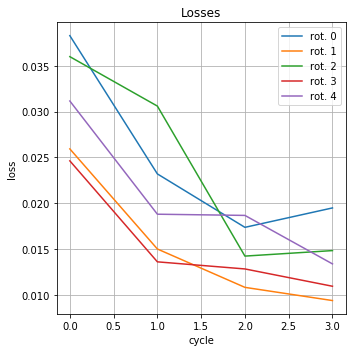

In [10]:
epochs = 1
rotations = 4

start_time = time.time()
rot_loss = []

ch_out_rotation = [[0, 5], [1, 6], [2, 7], [3, 8], [4, 9]]

for rot_nr in range(rotations):
    if rot_nr is 3:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0003
    for rot, ch_out in enumerate(ch_out_rotation):
        temp_loss = []
        epoch_loss = []
        model.make_gate(ch_out)
        
        for epoch in range(epochs):
            for idx, X in enumerate(X_train):
                optimizer.zero_grad()
                Y_pred = model(X)
                loss = criterion(Y_pred[ch_out], X[-1, ch_out])
                loss.backward()
                optimizer.step()
                temp_loss.append(loss.item())

            epoch_loss.append(np.mean(np.asarray(temp_loss)))
            print(f'Rotation: {rot} Epoch: {epoch} Loss: {epoch_loss[epoch]}')
        
        if rot_nr is 0:
            rot_loss.append(np.asarray(epoch_loss))
        else:
            rot_loss[rot] = np.concatenate((rot_loss[rot], np.asarray(epoch_loss)), 0)

total_time = time.time() - start_time
print('Time [min]: ' + str(total_time / 60))


fig, ax = plt.subplots(1, figsize=(5, 5))
for i in range(len(ch_out_rotation)):
    ax.plot(rot_loss[i], label='rot. ' + str(i))
    ax.legend()
ax.set_title('Losses')
ax.set_ylabel('loss')
ax.set_xlabel('cycle')
ax.grid()
fig.tight_layout()
#fig.savefig('fig_0430_losses.eps')

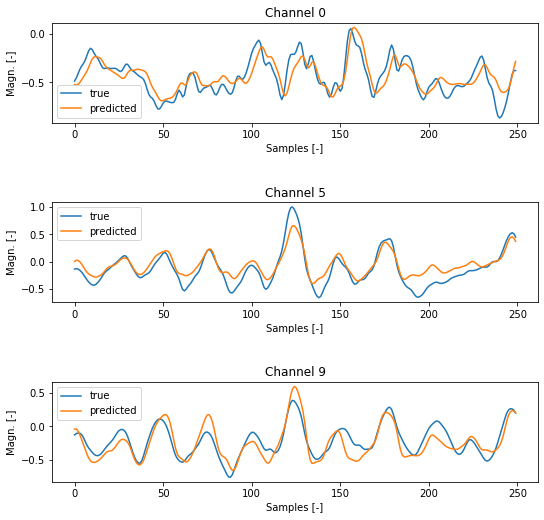

In [11]:
model.eval()

#ch = ch_out_rotation[3]
ch = [0, 5, 9]
model.make_gate(ch)
Y_preds = []
Y = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        Y_all = model(X).numpy()
        Y_preds.append(Y_all[ch]) 
        Y.append(X[-1, ch].numpy())
        
preds = np.asarray(Y_preds)
Y_test_np = np.asarray(Y)

fig, ax = plt.subplots(len(ch), figsize=(8, len(ch)*2.5))
fig.tight_layout(pad=3)
for i in range(len(ch)):
    ax[i].set_title('Channel ' + str(ch[i]))
    ax[i].plot(Y_test_np[:,i], label='true')
    ax[i].plot(preds[:,i], label='predicted')
    ax[i].set_xlabel('Samples [-]')
    ax[i].set_ylabel('Magn. [-]')
    ax[i].legend()

fig.subplots_adjust(hspace=.8)
#fig.savefig('fig_0430_predictions_frec-50_ch-7-8-9.eps')

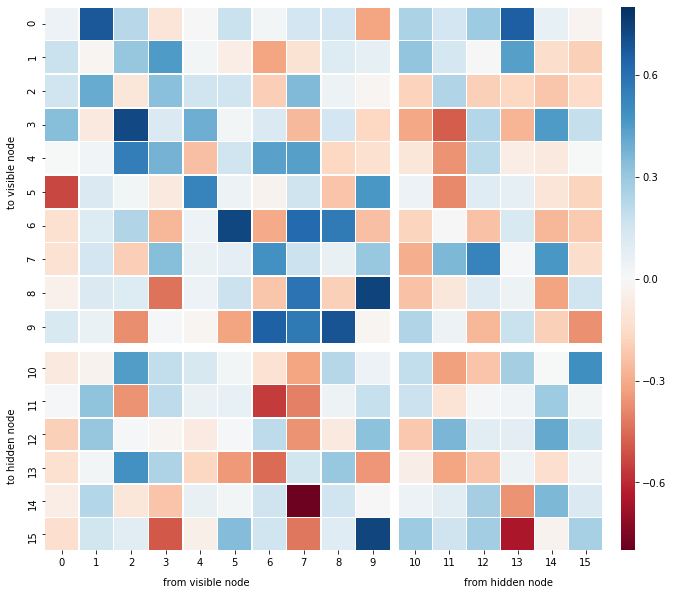

In [12]:
W = model.W.weight.data.numpy().copy()
#W = U.copy()

absolute = False
vmax = .8
linewidth = 0.5
vmin = -vmax
cmap = 'RdBu'
hticklabels = np.arange(channel_size, W.shape[0], 1)

if absolute:
    vmin = 0
    cmap = 'Blues'
    W = np.abs(W)
    
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(nrows=W.shape[0], ncols=W.shape[0])
cbar_ax = fig.add_axes([.925, .125, .02, .755])  # l,b,w,h

ax0 = fig.add_subplot(gs[:channel_size, :channel_size])
ax0.set_ylabel('to visible nodes')
ax0.get_xaxis().set_visible(False)

ax1 = fig.add_subplot(gs[:channel_size, channel_size:])
ax1.get_xaxis().set_visible(False), ax1.get_yaxis().set_visible(False)
ax1.set_ylabel('to hidden nodes')
ax1.set_xlabel('from visible nodes')

ax2 = fig.add_subplot(gs[channel_size:, :channel_size])
ax2.set_ylabel('to hidden nodes')
ax2.set_xlabel('from visible nodes')

ax3 = fig.add_subplot(gs[channel_size:, channel_size:])
ax3.get_yaxis().set_visible(False)
ax3.set_xlabel('from hidden nodes')

sns.heatmap(W[:channel_size, :channel_size],cmap=cmap, vmin=vmin, vmax=vmax, cbar=False, linewidths=linewidth, ax=ax0)
sns.heatmap(W[:channel_size, channel_size:],cmap=cmap, vmin=vmin, vmax=vmax, cbar=False, linewidths=linewidth, ax=ax1)
sns.heatmap(W[channel_size:, :channel_size],cmap=cmap, vmin=vmin, vmax=vmax, cbar=False, linewidths=linewidth, ax=ax2, yticklabels=hticklabels)
sns.heatmap(W[channel_size:, channel_size:],cmap=cmap, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax, linewidths=linewidth, ax=ax3, xticklabels=hticklabels)

fig.text(0.08, 0.65, 'to visible node', va='center', ha='center', rotation='vertical')
fig.text(0.08, 0.27, 'to hidden node', va='center', ha='center', rotation='vertical')
fig.text(0.35, 0.08, 'from visible node', va='center', ha='center')
fig.text(0.77, 0.08, 'from hidden node', va='center', ha='center')
fig.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('fig_0430_weights.eps')

In [13]:
torch.save(model.state_dict(), './FRNN_model.pth')

In [6]:
model.load_state_dict(torch.load('./FRNN_model2.pth'))

<All keys matched successfully>

In [100]:
if (v > 40):
    for idx, val in enumerate(hticklabels):
        if v%2 is 0:
            if val%2 is not 0:
                hticklabels.remove(val)
        if v%2 is not 0:
            if val%2 is 0:
                hticklabels.remove(val)

In [101]:
print(hticklabels)
print(hticks)

[67, 69, 71, 73, 75, 77, 79, 81, 83, 85]
[67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]


In [99]:
np.arange(1, h, 2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])

In [47]:
np.random.rand(U.shape[0], U.shape[1])

array([[0.70026729, 0.2695009 , 0.8681124 , 0.67327438, 0.989368  ,
        0.97162462, 0.63211557, 0.22271801, 0.65645682, 0.99751546,
        0.7482324 , 0.77458764, 0.97449434, 0.78783979, 0.6174357 ,
        0.4456776 ],
       [0.56594912, 0.97817413, 0.88117393, 0.93979915, 0.20770274,
        0.82195832, 0.36294656, 0.80347884, 0.01477513, 0.01170033,
        0.61909147, 0.62922089, 0.7405481 , 0.47320981, 0.5344401 ,
        0.9080909 ],
       [0.67206933, 0.60005184, 0.3694707 , 0.43768245, 0.35891479,
        0.75045399, 0.69301647, 0.66622459, 0.41762309, 0.00698593,
        0.88483707, 0.66137011, 0.62398076, 0.64430769, 0.63648695,
        0.17843246],
       [0.92663961, 0.98091498, 0.61878567, 0.78628043, 0.54518242,
        0.71315727, 0.50133805, 0.82129188, 0.61544666, 0.76757695,
        0.10389623, 0.47164891, 0.31539526, 0.48085854, 0.43362594,
        0.33269069],
       [0.04006935, 0.55956247, 0.34002417, 0.34026807, 0.13108619,
        0.41928491, 0.86614692, 

In [24]:
torch.tanh(torch.ones(1)*(-1))+1

tensor([0.2384])

In [50]:
channel_pos[5]

5